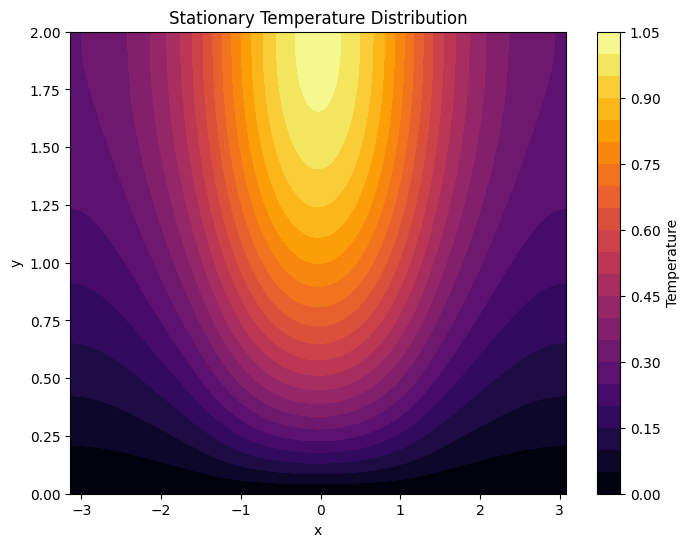

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags, kron, eye, csc_matrix
from scipy.sparse.linalg import spsolve

#Problem 2
Jx = 100
Jy = 50
hx = 2 * np.pi / Jx
hy = 2.0 / Jy

x = np.linspace(-np.pi, np.pi, Jx, endpoint=False)
y = np.linspace(0, 2, Jy+1)

Nx = Jx
Ny = Jy - 1
N = Nx * Ny

X_in, Y_in = np.meshgrid(x, y[1:Jy])
f_in = np.where((X_in >= -np.pi/2) & (X_in <= np.pi/2), -np.cos(X_in), 0)
f_vec = f_in.flatten()

e = np.ones(Nx)
diagonals_x = [e, -2*e, e]
offsets_x = [-1, 0, 1]
Ax = diags(diagonals_x, offsets_x, shape=(Nx, Nx)).tolil()
Ax[0, -1] = 1
Ax[-1, 0] = 1
Ax = Ax.tocsc()

e_y = np.ones(Ny)
Ay = diags([e_y, -2*e_y, e_y], offsets=[-1, 0, 1], shape=(Ny, Ny)).tolil()
Ay[-1, -2] = 2
Ay = Ay.tocsc()

A = kron(eye(Ny), Ax) / (hx**2) + kron(Ay, eye(Nx)) / (hy**2)
A = csc_matrix(A)

u_vec = spsolve(A, f_vec)
U_interior = u_vec.reshape((Ny, Nx))

U = np.zeros((Jy+1, Nx))
U[1:Jy, :] = U_interior
U[Jy, :] = U[Jy-1, :]

U_full = np.hstack([U, U[:, 0:1]])

plt.figure(figsize=(8,6))
X_plot, Y_plot = np.meshgrid(np.linspace(-np.pi, np.pi, Nx+1, endpoint=False), y)
plt.contourf(X_plot, Y_plot, U_full, levels=20, cmap='inferno')
plt.colorbar(label='Temperature')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Stationary Temperature Distribution')
plt.show()


L-shape ...
count =  200 displacement =  0.017879637570095194
count =  400 displacement =  0.032379746309166284
count =  600 displacement =  0.03234974563484979
count =  800 displacement =  0.02590922454614542
count =  1000 displacement =  0.013880439954076174
count =  1200 displacement =  0.04360669382934925
count =  1400 displacement =  0.03726436345631371
count =  1600 displacement =  0.015014049983676997
count =  1800 displacement =  0.057842241402153244
count =  2000 displacement =  0.019655962906424018
count =  2200 displacement =  0.02645466874472027
count =  2400 displacement =  0.043782403024980286
count =  2600 displacement =  0.030873251632710583
count =  2800 displacement =  0.02309014228929237
count =  3000 displacement =  0.05476863793382668
count =  3200 displacement =  0.03913479195989529
count =  3400 displacement =  0.011203610394943457
count =  3600 displacement =  0.04524883071769187
count =  3800 displacement =  0.01630838110006119
count =  4000 displacement =  0.0

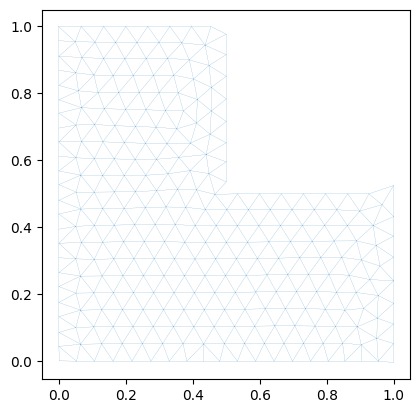

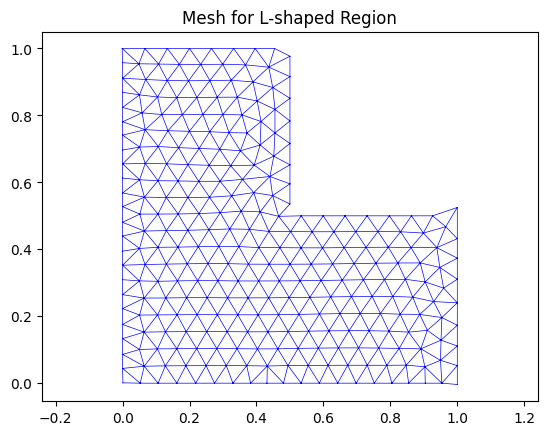

Pentagon with star hole ...
count =  200 displacement =  0.032233110044176866
count =  400 displacement =  0.014616159911710636
count =  600 displacement =  0.012581477043160873
count =  800 displacement =  0.006938971009460886
count =  1000 displacement =  0.006905133674314087
count =  1200 displacement =  0.01033688732673861
count =  1400 displacement =  0.006840395537838827
count =  1600 displacement =  0.006820488140710521
count =  1800 displacement =  0.006806562001541501
count =  2000 displacement =  0.006798260806420092
count =  2200 displacement =  0.0069325150786171885
count =  2400 displacement =  0.006810452722406624
count =  2600 displacement =  0.005304052921768494
count =  2800 displacement =  0.006994802455617625
count =  3000 displacement =  0.005631596112917244
count =  3200 displacement =  0.006809601110192368
count =  3400 displacement =  0.0068318976381886685
count =  3600 displacement =  0.005562164508638253
count =  3800 displacement =  0.006934120261529709
count 

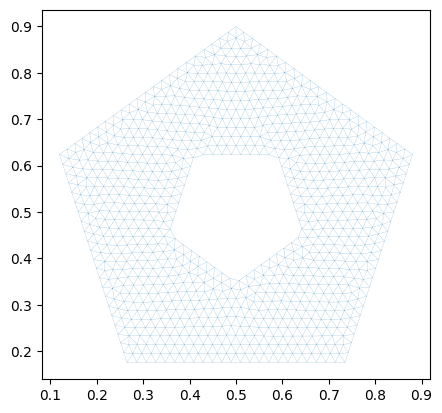

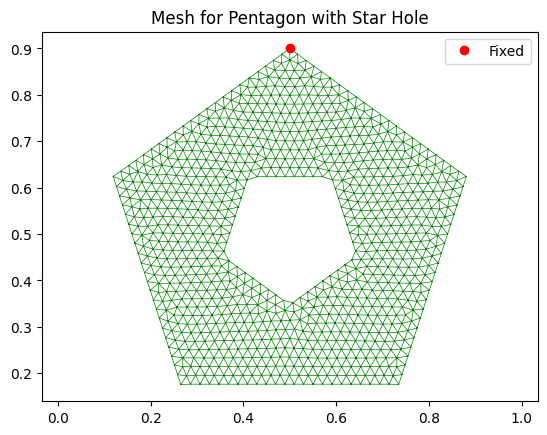

Half-circle bowl with top edge at y=0.5 ...
count =  200 displacement =  0.005845322519483221
count =  400 displacement =  0.0026015729326550325
count =  600 displacement =  0.002240102554068382
count =  800 displacement =  0.0022980870124628306
count =  1000 displacement =  0.0015884993207312772
count =  1200 displacement =  0.0011366154109972086
count =  1400 displacement =  0.0023257459956009512
count =  1600 displacement =  0.0015712804493404138
count =  1800 displacement =  0.0011274928597958514
count =  2000 displacement =  0.0023283846450543764
count =  2200 displacement =  0.0015563751683114932


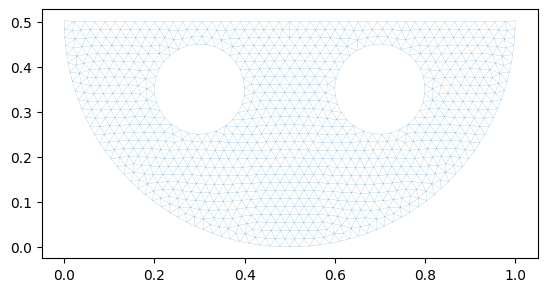

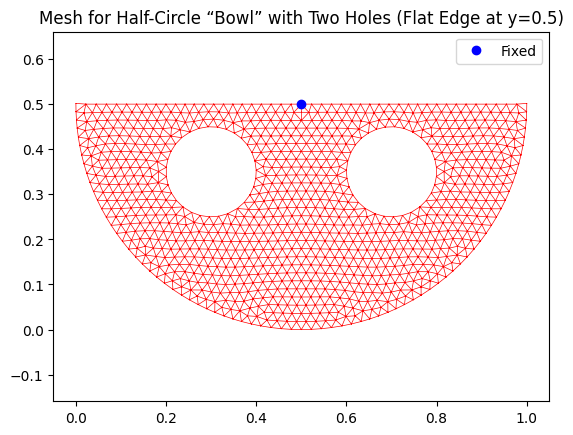

In [22]:
#content of distmesh.py
# Per-Olof Persson's code distmesh2D rewritten to Python and simplified
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial import Delaunay
from scipy import sparse

# input arguments
#      fd:        Distance function d(x,y)
#      fh:        Scaled edge length function h(x,y)
#      h0:        Initial edge length
#      bbox:      Bounding box [xmin,ymin; xmax,ymax] MASHA: [xmin,xmax,ymin,ymax]
#      pfix:      Fixed node positions (NFIXx2)

# output
#      pts:         Node positions (Nx2)
#      tri:         Triangle indices (NTx3)

def huniform(p):
    m,n = np.shape(p)
    return np.ones((m,1))

def ddiff(d1,d2):
    return np.maximum(d1,-d2)

def dcircle(p,xc,yc,r):
    return np.sqrt((p[:,0]-xc)**2+(p[:,1]-yc)**2)-r

def dellipse(p,xc,yc,rx,ry):
    return np.sqrt(((p[:,0]-xc)**2)/rx**2+((p[:,1]-yc)**2)/ry**2)-1

def drectangle(p,x1,x2,y1,y2):
    d1 = np.minimum(-y1+p[:,1],y2-p[:,1])
    d2 = np.minimum(d1,-x1+p[:,0])
    return -np.minimum(d2,x2-p[:,0])

def dintersect(d1,d2):
    return np.maximum(d1,d2)

def dunion(d1,d2):
    return np.minimum(d1,d2)

def dline(p,x1,y1,x2,y2):
    # signed distance from point p to line through (x1,y1) and  (x2,y2)
    # normal vector to the line
    nx = y1-y2
    ny = x2-x1
    nn = np.sqrt(nx*nx+ny*ny)
    # return (p-(x1,x2))*n/||n||
    return -((p[:,0]-x1)*nx+(p[:,1]-y1)*ny)/nn

def dtriangle(p,x1,y1,x2,y2,x3,y3):
    return np.maximum(dline(p,x1,y1,x2,y2),np.maximum(dline(p,x2,y2,x3,y3),dline(p,x3,y3,x1,y1)))

def triarea(pts,tri):
    # calculates areas of mesh triangles
    # p = [x_vec,y_vec]
    # tri = [ind0,ind1,ind2]
    d12 = pts[tri[:,1],:]-pts[tri[:,0],:]
    d13 = pts[tri[:,2],:]-pts[tri[:,0],:]
    A = d12[:,0]*d13[:,1]-d12[:,1]*d13[:,0]
    return A

def fixmesh(pts,tri):
    TOL = 1.0e-10
    # remove repeated nodes
    pts,idx = np.unique(pts,axis = 0,return_inverse = True)
    tri = np.reshape(idx[tri],np.shape(tri))

    # compute areas of mesh triangles
    A = triarea(pts,tri)
    idx_tri_reorder = np.argwhere(A < 0)
    Nidx = np.size(idx_tri_reorder)
    idx_tri_reorder = np.reshape(idx_tri_reorder,(Nidx,))
    if np.any(idx_tri_reorder):
        # reorder triangles with negative area
        tmp = tri[idx_tri_reorder,0]
        tri[idx_tri_reorder,0] = tri[idx_tri_reorder,1]
        tri[idx_tri_reorder,1] = tmp
    # remove triangles with too small area
    idx_keep = np.argwhere(np.absolute(A) > TOL*np.linalg.norm(A,np.inf))
    Nidx = np.size(idx_keep)
    idx_keep = np.reshape(idx_keep,(Nidx,))
    tri = tri[idx_keep,:]
    # remove unused nodes
    Ntri,m = np.shape(tri)
    t_col = np.reshape(tri,(Ntri*m,))
    idx,iidx = np.unique(t_col,return_inverse = True)
    pts = pts[idx,:]
    tri = np.reshape(iidx,(Ntri,m))
    return pts,tri

def distmesh2D(fd,fh,h0,bbox,pfix):
    # parameters
    dptol=.001
    ttol=.1
    Fscale=1.2
    deltat=.2
    geps=.001*h0
    deps=math.sqrt(np.finfo(float).eps)*h0
    MAXcount = 5000
    densityctrlfreq=30
    jshow = 200  # display progress every jshow iterations

    # define the initial set of points by
    # making a mesh of equilateral triangles with side h0 and
    # adding fixed points

    ax = np.arange(bbox[0],bbox[1],h0)
    ay = np.arange(bbox[2],bbox[3],h0*math.sqrt(3)*0.5)
    x,y = np.meshgrid(ax,ay)
    nx,ny = np.shape(x)
    nxy = nx*ny
    x[1:nx:2,:]=x[1:nx:2,:] + h0*0.5   # Shift odd rows
    x_vec = np.reshape(x, (nxy,1))
    y_vec = np.reshape(y, (nxy,1))
    pts = np.concatenate((x_vec,y_vec),axis=1)  # List of node coordinates
    # remove points outside the region
    jremove = np.argwhere(fd(pts) > geps)
    Nj = np.size(jremove)
    jremove = np.reshape(jremove,(Nj,))
    pts = np.delete(pts,jremove,0)
    if np.any(pfix): # if pfix is nonempty, i.e., there are fixed points
        pfix = np.unique(pfix, axis = 0) # extract unique rows in pfix
        nfix,d = np.shape(pfix)
        pts = np.concatenate((pfix,pts),axis=0) # prepend fixed points
    Npts = np.size(pts,0) # the number of points

    count = 0
    displacement = math.inf
    pts_old = math.inf

    while displacement > dptol and count < MAXcount:
        count = count + 1
        if max(np.sqrt(np.sum((pts-pts_old)**2,axis=1))/h0)>ttol:
            pts_old = pts
            tri = Delaunay(pts).simplices
            pts_ctr = (pts[tri[:,0],:]+pts[tri[:,1],:]+pts[tri[:,2],:])/3 # centroids of triangles
            tri = tri[fd(pts_ctr) <-geps,:] # keep only interior triangles
            Ntri = np.size(tri,axis = 0)
            bars = np.concatenate((tri[:,[0,1]],tri[:,[0,2]]),axis = 0)
            bars = np.concatenate((bars,tri[:,[1,2]]),axis = 0)
            bars = np.unique(np.sort(bars,axis = 1),axis = 0)
            Nbars,d = np.shape(bars)

        # move mesh points based on bar lengths L and forces F
        barvec=pts[bars[:,0],:]-pts[bars[:,1],:]   # List of bar vectors
        L=np.sqrt(np.sum(barvec**2,axis=1))     # L = Bar lengths
        L = np.reshape(L,(Nbars,1))
        hbars=fh((pts[bars[:,0],:]+pts[bars[:,1],:])/2)
        L0=hbars*Fscale*np.sqrt(sum(L**2)/np.sum(hbars**2)) # L0 = Desired lengths
        L0 = np.reshape(L0,(Nbars,1))

        # density control: remove points if they are too close
        if np.remainder(count,densityctrlfreq)==0 and np.any(L0>2*L):
            jremove = np.argwhere(L0>2*L)
            Nj = np.size(jremove)
            jremove = np.reshape(jremove,(Nj,))
            jremove = np.unique(np.reshape(bars[jremove,:],(Nj*2,)))
            jremove = np.setdiff1d(jremove,np.arange(nfix))
            pts = np.delete(pts,jremove,axis=0)
            Npts,d = np.shape(pts) # the number of points
            pts_old = math.inf
            continue

        F = np.maximum(L0-L,np.zeros_like(L0))
        Fvec=np.matmul(F/L,np.ones((1,2)))*barvec  # Bar forces (x,y components)
        I = bars[:,0]
        J = np.zeros_like(I)
        V = Fvec[:,0]
        F00 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,0]
        J = np.ones_like(I)
        V = Fvec[:,1]
        F01 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,1]
        J = np.zeros_like(I)
        V = -Fvec[:,0]
        F10 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        I = bars[:,1]
        J = np.ones_like(I)
        V = -Fvec[:,1]
        F11 = sparse.coo_matrix((V,(I,J)),shape=(Npts,2)).toarray()
        Ftot = F00+F01+F10+F11
        Ftot[0:nfix,:] = 0 # force = 0 at fixed points
        pts = pts + deltat*Ftot   # Update node positions

        # Bring outside points back to the boundary
        d = fd(pts)
        idx = np.argwhere(d > 0) # find points outside the domain
        Nidx = np.size(idx)
        idx = np.reshape(idx,(Nidx,))

        dx = np.zeros_like(pts[idx,:])
        dx[:,0] = deps
        dgradx = (fd(pts[idx,:]+dx) - d[idx])/deps
        dy = np.zeros_like(pts[idx,:])
        dy[:,1] = deps
        dgrady = (fd(pts[idx,:]+dy) - d[idx])/deps
        dgrad2 = dgradx**2 + dgrady**2
        pts[idx,:] = pts[idx,:] - np.concatenate((np.reshape(d[idx]*dgradx/dgrad2,(Nidx,1)),\
                                                  np.reshape(d[idx]*dgrady/dgrad2,(Nidx,1))),axis=1)

        # termination criterion
        idx = np.argwhere(d < - geps) # find interior nodes
        Nidx = np.size(idx)
        idx = np.reshape(idx,(Nidx,))
        displacement = np.amax(np.sqrt(np.sum(deltat*Ftot[idx,:]**2,axis=1))/h0) # mamimal displacement, scaled
        if np.remainder(count,jshow)==0:
            print("count = ",count,"displacement = ",displacement)

    pts,tri = fixmesh(pts,tri)
    plt.triplot(pts[:,0],pts[:,1],tri,linewidth=0.1)
    axes=plt.gca()
    axes.set_aspect(1)
    return pts,tri



#Problem 3 implementation


def fd_L(p):

    d_big = drectangle(p, 0,1, 0,1)
    d_cut = drectangle(p, 0.5,1, 0.5,1)
    return ddiff(d_big, d_cut)

def demo_L_shape():
    bbox = [0,1, 0,1]
    h0   = 0.05
    pfix = np.array([[0.001,0.001]])
    pts, tri = distmesh2D(fd_L, huniform, h0, bbox, pfix)
    plt.figure()
    plt.triplot(pts[:,0], pts[:,1], tri, 'b-', lw=0.5)
    plt.axis('equal')
    plt.title('Mesh for L-shaped Region')
    plt.show()


def dpoly(p, verts):

    nv = len(verts)
    dlist = []
    for i in range(nv):
        x1, y1 = verts[i]
        x2, y2 = verts[(i+1) % nv]
        dlist.append(dline(p, x1, y1, x2, y2))
    dpoly_out = dlist[0]
    for i in range(1, nv):
        dpoly_out = dintersect(dpoly_out, dlist[i])
    return dpoly_out

def outer_pentagon_vertices(center=(0.5,0.5), R=0.4):

    angles = np.linspace(0, 2*np.pi, 6)[:-1] + np.pi/2
    verts = []
    for a in angles:
        x = center[0] + R*np.cos(a)
        y = center[1] + R*np.sin(a)
        verts.append((x,y))
    return verts

def star5_vertices(center=(0.5,0.5), R=0.4):

    base = outer_pentagon_vertices(center, R)
    idx_star = [0,2,4,1,3]
    return [base[i] for i in idx_star]

def fd_pentagon_star(p):

    d_out  = dpoly(p, outer_pentagon_vertices())
    d_star = dpoly(p, star5_vertices())
    return ddiff(d_out, d_star)

def demo_pentagon_star():
    bbox = [0,1, 0,1]
    h0   = 0.02
    pfix = np.array([[0.5,0.9]])
    pts, tri = distmesh2D(fd_pentagon_star, huniform, h0, bbox, pfix)
    plt.figure()
    plt.triplot(pts[:,0], pts[:,1], tri, 'g-', lw=0.5)
    plt.plot(pfix[:,0], pfix[:,1], 'ro', label='Fixed')
    plt.axis('equal')
    plt.title('Mesh for Pentagon with Star Hole')
    plt.legend()
    plt.show()


def fd_halfcircle_bowl(p):

    d_circ = dcircle(p, 0.5, 0.5, 0.5)

    d_lin_forward = dline(p, 1,0.5, 0,0.5)
    d_main = dintersect(d_circ, d_lin_forward)

    d_hole1 = dcircle(p, 0.3, 0.35, 0.1)
    d_hole2 = dcircle(p, 0.7, 0.35, 0.1)
    return ddiff(ddiff(d_main, d_hole1), d_hole2)

def demo_halfcircle_bowl():

    bbox = [0,1, -0.1,0.6]
    h0   = 0.02
    pfix = np.array([[0.5,0.5]])
    pts, tri = distmesh2D(fd_halfcircle_bowl, huniform, h0, bbox, pfix)

    plt.figure()
    plt.triplot(pts[:,0], pts[:,1], tri, 'r-', lw=0.5)
    plt.plot(pfix[:,0], pfix[:,1], 'bo', label='Fixed')
    plt.axis('equal')
    plt.title('Mesh for Half-Circle “Bowl” with Two Holes (Flat Edge at y=0.5)')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    print("L-shape ...")
    demo_L_shape()

    print("Pentagon with star hole ...")
    demo_pentagon_star()

    print("Half-circle bowl with top edge at y=0.5 ...")
    demo_halfcircle_bowl()


